In [36]:
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
# from util import load_dataset, read_sensor_data_from_file
from resnet1d import ResNet1D, MyDataset
from acnn1d import ACNN, MyDataset
from crnn1d import CRNN, MyDataset
from net1d import Net1D, MyDataset

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tensorboardX import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [37]:
# 数据读取部分
def read_sensor_data_from_file(file_path):
    """
    读取txt文件中的数据
    """
    data = np.loadtxt(file_path)
    return data

def load_dataset(data_folder):
    """
    从指定的文件夹加载数据集。数据文件在多层目录中，标签由文件夹名称确定。
    """
    all_X = []
    all_Y = []
    label_map = {'Eucalyptus': 0, 'Rosewood': 1, 'Sandalwood': 2}

    for subfolder_name in os.listdir(data_folder):
        subfolder_path = os.path.join(data_folder, subfolder_name)
        if not os.path.isdir(subfolder_path):
            continue
        
        if subfolder_name not in label_map:
            print(f"Unknown label folder: {subfolder_name}")
            continue
        
        label = label_map[subfolder_name]
        
        for root, dirs, files in os.walk(subfolder_path):
            for file in files:
                if file.endswith('.txt'):
                    file_path = os.path.join(root, file)
                    try:
                        data = read_sensor_data_from_file(file_path)
                        if data.shape == (640, 8):
                            data = np.transpose(data, (1, 0))  # 将数据从 (1269, 8) 转为 (8, 1269)
                            all_X.append(data)
                            all_Y.append(label)
                        else:
                            print(f"File {file_path} has unexpected shape {data.shape}")
                    except ValueError as e:
                        print(e)

    all_X = np.array(all_X)
    all_Y = np.array(all_Y)
    return all_X, all_Y

def preprocess_data(data_folder, window_size=640, stride=8):
    # 加载数据
    all_X, all_Y = load_dataset(data_folder)
    
    # # 数据标准化
    # for i in range(len(all_X)):
    #     tmp_data = all_X[i]
    #     tmp_std = np.std(tmp_data)
    #     tmp_mean = np.mean(tmp_data)
    #     all_X[i] = (tmp_data - tmp_mean) / tmp_std
    
    # 划分训练和测试集
    X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size=0.2, random_state=42)
    
    # # 数据形状调整 (n_samples, n_channel, n_length)
    # X_train = np.expand_dims(X_train, 1)
    # X_test = np.expand_dims(X_test, 1)
    
    return X_train, X_test, Y_train, Y_test



In [38]:
if __name__ == "__main__":
    is_debug = False
    
    batch_size = 64
    writer = SummaryWriter('resnet1d/logs/acnn')

    # 加载并预处理数据
    data_folder = 'C:/Users/22209/Desktop/气体论文/Woodgass/PAA640'  # 替换为你的数据文件夹路径
    X_train, X_test, Y_train, Y_test = preprocess_data(data_folder)
    
    # 将数据加载到DataLoader
    dataset = MyDataset(X_train, Y_train)
    dataset_test = MyDataset(X_test, Y_test)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, drop_last=False)

In [45]:
# 定义模型
device_str = "cuda"
device = torch.device(device_str if torch.cuda.is_available() else "cpu")
model = ACNN(
    in_channels=8,  # 修改输入通道数为8，因为你的数据是(2700, 8, 1269)
    out_channels=128, 
    att_channels=4,
    n_len_seg=320, 
    verbose=False,
    n_classes=3,  # 修改类别数为3
    device=device)
model.to(device)

# 查看模型
prog_iter = tqdm(dataloader, desc="init", leave=False)
for batch_idx, batch in enumerate(prog_iter):
    input_x, input_y = tuple(t.to(device) for t in batch)
    pred = model(input_x)
    break


In [46]:
# make model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# ----------------resnet------------------------
# model = ResNet1D(
#     in_channels=8, 
#     base_filters=128,  #64
#     kernel_size=9,  
#     stride=2, 
#     n_block=48, #34
#     groups=8,
#     n_classes=3, 
#     downsample_gap=4, 
#     increasefilter_gap=12, 
#     verbose=False)
# model.to(device)
# summary(model, (data.shape[1], data.shape[2]))

#----------------ACNN(Attention)-----------------
# # make model
# device_str = "cuda"
# device = torch.device(device_str if torch.cuda.is_available() else "cpu")
# model = ACNN(
#     in_channels=8, 
#     out_channels=128, 
#     att_channels=16,
#     n_len_seg=16, 
#     verbose=False,
#     n_classes=3,
#     device=device)
# model.to(device)



#----------------DNN-----------------------------
# model = Net1D(
#     in_channels=1, 
#     base_filters=256, 
#     ratio=1.0, 
#     filter_mul_list=[1,2,2,4,4,8,8], 
#     m_blocks_list=[2,2,2,2,2,2,2], 
#     kernel_size=16, 
#     stride=2, 
#     groups=32,
#     verbose=True, 
#     n_classes=4)
# model.to(device)
# summary(model, (X_train.shape[1], X_train.shape[2]), device=device_str)
# exit()

#----------------TCNN(Transformer)-----------------
# device_str = "cuda"
# device = torch.device(device_str if torch.cuda.is_available() else "cpu")
# model = CRNN(
#     in_channels=1, 
#     out_channels=16, 
#     n_len_seg=50, 
#     verbose=False,
#     n_classes=2,
#     device=device)

# summary(model, torch.zeros(1, 1, 3000))

# model.to(device)

#----------------CRNN(LSTM)------------------------
# device_str = "cuda"
# device = torch.device(device_str if torch.cuda.is_available() else "cpu")
# model = CRNN(
#     in_channels=1, 
#     out_channels=16, 
#     n_len_seg=50, 
#     verbose=False,
#     n_classes=2,
#     device=device)

# summary(model, torch.zeros(1, 1, 3000))

# model.to(device)

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch:   0%|          | 1/250 [00:00<03:28,  1.20it/s]

Epoch 1.15: adjusting learning rate of group 0 to 9.9869e-04.
Epoch 1, Validation Loss: 1.1517


Epoch:   1%|          | 2/250 [00:01<02:09,  1.92it/s]

Epoch 1.09: adjusting learning rate of group 0 to 9.9882e-04.
Epoch 2, Validation Loss: 1.0931


Epoch:   1%|          | 3/250 [00:01<01:38,  2.51it/s]

Epoch 1.09: adjusting learning rate of group 0 to 9.9883e-04.
Epoch 3, Validation Loss: 1.0913


Epoch:   2%|▏         | 4/250 [00:01<01:24,  2.93it/s]

Epoch 1.09: adjusting learning rate of group 0 to 9.9883e-04.
Epoch 4, Validation Loss: 1.0880


Epoch:   2%|▏         | 5/250 [00:01<01:18,  3.14it/s]

Epoch 1.08: adjusting learning rate of group 0 to 9.9884e-04.
Epoch 5, Validation Loss: 1.0835


Epoch:   2%|▏         | 6/250 [00:02<01:14,  3.27it/s]

Epoch 1.07: adjusting learning rate of group 0 to 9.9887e-04.
Epoch 6, Validation Loss: 1.0717


Epoch:   3%|▎         | 7/250 [00:02<01:22,  2.96it/s]

Epoch 1.05: adjusting learning rate of group 0 to 9.9891e-04.
Epoch 7, Validation Loss: 1.0525


Epoch:   3%|▎         | 8/250 [00:02<01:15,  3.20it/s]

Epoch 1.04: adjusting learning rate of group 0 to 9.9894e-04.
Epoch 8, Validation Loss: 1.0386


Epoch:   4%|▎         | 9/250 [00:03<01:21,  2.97it/s]

Epoch 0.99: adjusting learning rate of group 0 to 9.9903e-04.
Epoch 9, Validation Loss: 0.9935


Epoch:   4%|▍         | 10/250 [00:03<01:23,  2.87it/s]

Epoch 0.95: adjusting learning rate of group 0 to 9.9910e-04.
Epoch 10, Validation Loss: 0.9546


Epoch:   4%|▍         | 11/250 [00:03<01:24,  2.84it/s]

Epoch 0.92: adjusting learning rate of group 0 to 9.9917e-04.
Epoch 11, Validation Loss: 0.9186


Epoch:   5%|▍         | 12/250 [00:04<01:31,  2.61it/s]

Epoch 0.91: adjusting learning rate of group 0 to 9.9919e-04.
Epoch 12, Validation Loss: 0.9087


Epoch:   5%|▌         | 13/250 [00:04<01:36,  2.46it/s]

Epoch 0.89: adjusting learning rate of group 0 to 9.9922e-04.
Epoch 13, Validation Loss: 0.8877


Epoch:   6%|▌         | 14/250 [00:05<01:35,  2.48it/s]

Epoch 0.91: adjusting learning rate of group 0 to 9.9918e-04.
Epoch 14, Validation Loss: 0.9106


Epoch:   6%|▌         | 15/250 [00:05<01:40,  2.35it/s]

Epoch 0.87: adjusting learning rate of group 0 to 9.9925e-04.
Epoch 15, Validation Loss: 0.8747


Epoch:   6%|▋         | 16/250 [00:06<01:39,  2.36it/s]

Epoch 0.90: adjusting learning rate of group 0 to 9.9921e-04.
Epoch 16, Validation Loss: 0.8981


Epoch:   7%|▋         | 17/250 [00:06<01:40,  2.32it/s]

Epoch 0.88: adjusting learning rate of group 0 to 9.9923e-04.
Epoch 17, Validation Loss: 0.8815


Epoch:   7%|▋         | 18/250 [00:07<01:45,  2.20it/s]

Epoch 0.85: adjusting learning rate of group 0 to 9.9929e-04.
Epoch 18, Validation Loss: 0.8499


Epoch:   8%|▊         | 19/250 [00:07<01:46,  2.16it/s]

Epoch 0.84: adjusting learning rate of group 0 to 9.9930e-04.
Epoch 19, Validation Loss: 0.8417


Epoch:   8%|▊         | 20/250 [00:08<01:44,  2.20it/s]

Epoch 0.88: adjusting learning rate of group 0 to 9.9923e-04.
Epoch 20, Validation Loss: 0.8842


Epoch:   8%|▊         | 21/250 [00:08<01:41,  2.25it/s]

Epoch 0.99: adjusting learning rate of group 0 to 9.9904e-04.
Epoch 21, Validation Loss: 0.9873


Epoch:   9%|▉         | 22/250 [00:08<01:37,  2.34it/s]

Epoch 0.89: adjusting learning rate of group 0 to 9.9922e-04.
Epoch 22, Validation Loss: 0.8887


Epoch:   9%|▉         | 23/250 [00:09<01:37,  2.33it/s]

Epoch 0.86: adjusting learning rate of group 0 to 9.9927e-04.
Epoch 23, Validation Loss: 0.8580


Epoch:  10%|▉         | 24/250 [00:09<01:37,  2.32it/s]

Epoch 0.84: adjusting learning rate of group 0 to 9.9930e-04.
Epoch 24, Validation Loss: 0.8405


Epoch:  10%|█         | 25/250 [00:10<01:36,  2.34it/s]

Epoch 0.83: adjusting learning rate of group 0 to 9.9931e-04.
Epoch 25, Validation Loss: 0.8343


Epoch:  10%|█         | 26/250 [00:10<01:31,  2.46it/s]

Epoch 0.87: adjusting learning rate of group 0 to 9.9925e-04.
Epoch 26, Validation Loss: 0.8699


Epoch:  11%|█         | 27/250 [00:10<01:26,  2.57it/s]

Epoch 0.84: adjusting learning rate of group 0 to 9.9930e-04.
Epoch 27, Validation Loss: 0.8409


Epoch:  11%|█         | 28/250 [00:11<01:24,  2.64it/s]

Epoch 0.87: adjusting learning rate of group 0 to 9.9925e-04.
Epoch 28, Validation Loss: 0.8749


Epoch:  12%|█▏        | 29/250 [00:11<01:24,  2.62it/s]

Epoch 0.84: adjusting learning rate of group 0 to 9.9930e-04.
Epoch 29, Validation Loss: 0.8424


Epoch:  12%|█▏        | 30/250 [00:12<01:31,  2.40it/s]

Epoch 0.83: adjusting learning rate of group 0 to 9.9932e-04.
Epoch 30, Validation Loss: 0.8298


Epoch:  12%|█▏        | 31/250 [00:12<01:26,  2.52it/s]

Epoch 0.82: adjusting learning rate of group 0 to 9.9934e-04.
Epoch 31, Validation Loss: 0.8199


Epoch:  13%|█▎        | 32/250 [00:12<01:24,  2.58it/s]

Epoch 0.83: adjusting learning rate of group 0 to 9.9932e-04.
Epoch 32, Validation Loss: 0.8296


Epoch:  13%|█▎        | 33/250 [00:13<01:25,  2.55it/s]

Epoch 0.85: adjusting learning rate of group 0 to 9.9929e-04.
Epoch 33, Validation Loss: 0.8469


Epoch:  14%|█▎        | 34/250 [00:13<01:20,  2.67it/s]

Epoch 0.82: adjusting learning rate of group 0 to 9.9934e-04.
Epoch 34, Validation Loss: 0.8208


Epoch:  14%|█▍        | 35/250 [00:13<01:17,  2.76it/s]

Epoch 0.83: adjusting learning rate of group 0 to 9.9932e-04.
Epoch 35, Validation Loss: 0.8278


Epoch:  14%|█▍        | 36/250 [00:14<01:22,  2.59it/s]

Epoch 0.81: adjusting learning rate of group 0 to 9.9936e-04.
Epoch 36, Validation Loss: 0.8053


Epoch:  15%|█▍        | 37/250 [00:14<01:19,  2.68it/s]

Epoch 0.83: adjusting learning rate of group 0 to 9.9933e-04.
Epoch 37, Validation Loss: 0.8255


Epoch:  15%|█▌        | 38/250 [00:14<01:14,  2.83it/s]

Epoch 0.85: adjusting learning rate of group 0 to 9.9928e-04.
Epoch 38, Validation Loss: 0.8542


Epoch:  16%|█▌        | 39/250 [00:15<01:16,  2.76it/s]

Epoch 0.82: adjusting learning rate of group 0 to 9.9934e-04.
Epoch 39, Validation Loss: 0.8201


Epoch:  16%|█▌        | 40/250 [00:15<01:16,  2.73it/s]

Epoch 0.80: adjusting learning rate of group 0 to 9.9937e-04.
Epoch 40, Validation Loss: 0.8023


Epoch:  16%|█▋        | 41/250 [00:16<01:15,  2.77it/s]

Epoch 0.81: adjusting learning rate of group 0 to 9.9935e-04.
Epoch 41, Validation Loss: 0.8093


Epoch:  17%|█▋        | 42/250 [00:16<01:21,  2.55it/s]

Epoch 0.83: adjusting learning rate of group 0 to 9.9933e-04.
Epoch 42, Validation Loss: 0.8258


Epoch:  17%|█▋        | 43/250 [00:16<01:22,  2.51it/s]

Epoch 0.82: adjusting learning rate of group 0 to 9.9934e-04.
Epoch 43, Validation Loss: 0.8211


Epoch:  18%|█▊        | 44/250 [00:17<01:19,  2.60it/s]

Epoch 0.82: adjusting learning rate of group 0 to 9.9934e-04.
Epoch 44, Validation Loss: 0.8159


Epoch:  18%|█▊        | 45/250 [00:17<01:19,  2.58it/s]

Epoch 0.80: adjusting learning rate of group 0 to 9.9937e-04.
Epoch 45, Validation Loss: 0.8019


Epoch:  18%|█▊        | 46/250 [00:18<01:18,  2.58it/s]

Epoch 0.82: adjusting learning rate of group 0 to 9.9934e-04.
Epoch 46, Validation Loss: 0.8186


Epoch:  19%|█▉        | 47/250 [00:18<01:22,  2.47it/s]

Epoch 0.79: adjusting learning rate of group 0 to 9.9938e-04.
Epoch 47, Validation Loss: 0.7950


Epoch:  19%|█▉        | 48/250 [00:19<01:26,  2.34it/s]

Epoch 0.82: adjusting learning rate of group 0 to 9.9934e-04.
Epoch 48, Validation Loss: 0.8212


Epoch:  20%|█▉        | 49/250 [00:19<01:26,  2.33it/s]

Epoch 0.79: adjusting learning rate of group 0 to 9.9938e-04.
Epoch 49, Validation Loss: 0.7947


Epoch:  20%|██        | 50/250 [00:19<01:27,  2.30it/s]

Epoch 0.79: adjusting learning rate of group 0 to 9.9938e-04.
Epoch 50, Validation Loss: 0.7920


Epoch:  20%|██        | 51/250 [00:20<01:25,  2.32it/s]

Epoch 0.81: adjusting learning rate of group 0 to 9.9935e-04.
Epoch 51, Validation Loss: 0.8141


Epoch:  21%|██        | 52/250 [00:20<01:19,  2.49it/s]

Epoch 0.84: adjusting learning rate of group 0 to 9.9930e-04.
Epoch 52, Validation Loss: 0.8417


Epoch:  21%|██        | 53/250 [00:21<01:23,  2.36it/s]

Epoch 0.81: adjusting learning rate of group 0 to 9.9935e-04.
Epoch 53, Validation Loss: 0.8143


Epoch:  22%|██▏       | 54/250 [00:21<01:23,  2.36it/s]

Epoch 0.83: adjusting learning rate of group 0 to 9.9932e-04.
Epoch 54, Validation Loss: 0.8321


Epoch:  22%|██▏       | 55/250 [00:21<01:18,  2.48it/s]

Epoch 0.80: adjusting learning rate of group 0 to 9.9936e-04.
Epoch 55, Validation Loss: 0.8028


Epoch:  22%|██▏       | 56/250 [00:22<01:19,  2.43it/s]

Epoch 0.82: adjusting learning rate of group 0 to 9.9934e-04.
Epoch 56, Validation Loss: 0.8192


Epoch:  23%|██▎       | 57/250 [00:22<01:18,  2.47it/s]

Epoch 0.81: adjusting learning rate of group 0 to 9.9935e-04.
Epoch 57, Validation Loss: 0.8097


Epoch:  23%|██▎       | 58/250 [00:23<01:19,  2.42it/s]

Epoch 0.81: adjusting learning rate of group 0 to 9.9935e-04.
Epoch 58, Validation Loss: 0.8091


Epoch:  24%|██▎       | 59/250 [00:23<01:18,  2.42it/s]

Epoch 0.80: adjusting learning rate of group 0 to 9.9938e-04.
Epoch 59, Validation Loss: 0.7962


Epoch:  24%|██▍       | 60/250 [00:24<01:22,  2.30it/s]

Epoch 0.80: adjusting learning rate of group 0 to 9.9937e-04.
Epoch 60, Validation Loss: 0.8012


Epoch:  24%|██▍       | 61/250 [00:24<01:22,  2.30it/s]

Epoch 0.80: adjusting learning rate of group 0 to 9.9936e-04.
Epoch 61, Validation Loss: 0.8048


Epoch:  25%|██▍       | 62/250 [00:24<01:20,  2.34it/s]

Epoch 0.79: adjusting learning rate of group 0 to 9.9939e-04.
Epoch 62, Validation Loss: 0.7871


Epoch:  25%|██▌       | 63/250 [00:25<01:20,  2.33it/s]

Epoch 0.81: adjusting learning rate of group 0 to 9.9935e-04.
Epoch 63, Validation Loss: 0.8112


Epoch:  26%|██▌       | 64/250 [00:25<01:20,  2.31it/s]

Epoch 0.80: adjusting learning rate of group 0 to 9.9937e-04.
Epoch 64, Validation Loss: 0.7987


Epoch:  26%|██▌       | 65/250 [00:26<01:20,  2.30it/s]

Epoch 0.80: adjusting learning rate of group 0 to 9.9937e-04.
Epoch 65, Validation Loss: 0.8006


Epoch:  26%|██▋       | 66/250 [00:26<01:17,  2.38it/s]

Epoch 0.87: adjusting learning rate of group 0 to 9.9925e-04.
Epoch 66, Validation Loss: 0.8726


Epoch:  27%|██▋       | 67/250 [00:27<01:18,  2.34it/s]

Epoch 0.81: adjusting learning rate of group 0 to 9.9936e-04.
Epoch 67, Validation Loss: 0.8072


Epoch:  27%|██▋       | 68/250 [00:27<01:17,  2.36it/s]

Epoch 0.81: adjusting learning rate of group 0 to 9.9936e-04.
Epoch 68, Validation Loss: 0.8071


Epoch:  28%|██▊       | 69/250 [00:27<01:18,  2.32it/s]

Epoch 0.81: adjusting learning rate of group 0 to 9.9935e-04.
Epoch 69, Validation Loss: 0.8129


Epoch:  28%|██▊       | 70/250 [00:28<01:19,  2.27it/s]

Epoch 0.79: adjusting learning rate of group 0 to 9.9938e-04.
Epoch 70, Validation Loss: 0.7927


Epoch:  28%|██▊       | 71/250 [00:28<01:18,  2.27it/s]

Epoch 0.84: adjusting learning rate of group 0 to 9.9931e-04.
Epoch 71, Validation Loss: 0.8359


Epoch:  29%|██▉       | 72/250 [00:29<01:15,  2.36it/s]

Epoch 0.81: adjusting learning rate of group 0 to 9.9936e-04.
Epoch 72, Validation Loss: 0.8084


Epoch:  29%|██▉       | 73/250 [00:29<01:15,  2.34it/s]

Epoch 0.79: adjusting learning rate of group 0 to 9.9938e-04.
Epoch 73, Validation Loss: 0.7930


Epoch:  30%|██▉       | 74/250 [00:30<01:13,  2.39it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9939e-04.
Epoch 74, Validation Loss: 0.7841


Epoch:  30%|███       | 75/250 [00:30<01:13,  2.39it/s]

Epoch 0.86: adjusting learning rate of group 0 to 9.9927e-04.
Epoch 75, Validation Loss: 0.8586


Epoch:  30%|███       | 76/250 [00:30<01:14,  2.33it/s]

Epoch 0.79: adjusting learning rate of group 0 to 9.9938e-04.
Epoch 76, Validation Loss: 0.7903


Epoch:  31%|███       | 77/250 [00:31<01:11,  2.44it/s]

Epoch 0.79: adjusting learning rate of group 0 to 9.9938e-04.
Epoch 77, Validation Loss: 0.7908


Epoch:  31%|███       | 78/250 [00:31<01:09,  2.48it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9939e-04.
Epoch 78, Validation Loss: 0.7836


Epoch:  32%|███▏      | 79/250 [00:32<01:07,  2.53it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9940e-04.
Epoch 79, Validation Loss: 0.7799


Epoch:  32%|███▏      | 80/250 [00:32<01:07,  2.52it/s]

Epoch 0.80: adjusting learning rate of group 0 to 9.9937e-04.
Epoch 80, Validation Loss: 0.7971


Epoch:  32%|███▏      | 81/250 [00:32<01:01,  2.77it/s]

Epoch 0.80: adjusting learning rate of group 0 to 9.9937e-04.
Epoch 81, Validation Loss: 0.8009


Epoch:  33%|███▎      | 82/250 [00:33<00:55,  3.02it/s]

Epoch 0.80: adjusting learning rate of group 0 to 9.9937e-04.
Epoch 82, Validation Loss: 0.7968


Epoch:  33%|███▎      | 83/250 [00:33<00:56,  2.94it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9939e-04.
Epoch 83, Validation Loss: 0.7848


Epoch:  34%|███▎      | 84/250 [00:33<00:53,  3.08it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9940e-04.
Epoch 84, Validation Loss: 0.7797


Epoch:  34%|███▍      | 85/250 [00:33<00:51,  3.22it/s]

Epoch 0.87: adjusting learning rate of group 0 to 9.9925e-04.
Epoch 85, Validation Loss: 0.8736


Epoch:  34%|███▍      | 86/250 [00:34<00:53,  3.08it/s]

Epoch 0.79: adjusting learning rate of group 0 to 9.9939e-04.
Epoch 86, Validation Loss: 0.7893


Epoch:  35%|███▍      | 87/250 [00:34<00:53,  3.03it/s]

Epoch 0.86: adjusting learning rate of group 0 to 9.9927e-04.
Epoch 87, Validation Loss: 0.8604


Epoch:  35%|███▌      | 88/250 [00:34<00:51,  3.17it/s]

Epoch 0.79: adjusting learning rate of group 0 to 9.9938e-04.
Epoch 88, Validation Loss: 0.7916


Epoch:  36%|███▌      | 89/250 [00:35<00:54,  2.93it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9940e-04.
Epoch 89, Validation Loss: 0.7786


Epoch:  36%|███▌      | 90/250 [00:35<00:52,  3.06it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9940e-04.
Epoch 90, Validation Loss: 0.7830


Epoch:  36%|███▋      | 91/250 [00:35<00:50,  3.12it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9940e-04.
Epoch 91, Validation Loss: 0.7790


Epoch:  37%|███▋      | 92/250 [00:36<00:49,  3.17it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9941e-04.
Epoch 92, Validation Loss: 0.7764


Epoch:  37%|███▋      | 93/250 [00:36<00:49,  3.19it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9940e-04.
Epoch 93, Validation Loss: 0.7832


Epoch:  38%|███▊      | 94/250 [00:36<00:46,  3.33it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9940e-04.
Epoch 94, Validation Loss: 0.7777


Epoch:  38%|███▊      | 95/250 [00:37<00:48,  3.21it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9940e-04.
Epoch 95, Validation Loss: 0.7794


Epoch:  38%|███▊      | 96/250 [00:37<00:48,  3.20it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9940e-04.
Epoch 96, Validation Loss: 0.7784


Epoch:  39%|███▉      | 97/250 [00:37<00:46,  3.27it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9940e-04.
Epoch 97, Validation Loss: 0.7787


Epoch:  39%|███▉      | 98/250 [00:38<00:45,  3.37it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9941e-04.
Epoch 98, Validation Loss: 0.7766


Epoch:  40%|███▉      | 99/250 [00:38<00:44,  3.42it/s]

Epoch 0.85: adjusting learning rate of group 0 to 9.9929e-04.
Epoch 99, Validation Loss: 0.8495


Epoch:  40%|████      | 100/250 [00:38<00:42,  3.55it/s]

Epoch 0.80: adjusting learning rate of group 0 to 9.9938e-04.
Epoch 100, Validation Loss: 0.7956


Epoch:  40%|████      | 101/250 [00:39<00:50,  2.96it/s]

Epoch 0.77: adjusting learning rate of group 0 to 9.9941e-04.
Epoch 101, Validation Loss: 0.7728


Epoch:  41%|████      | 102/250 [00:39<00:47,  3.08it/s]

Epoch 0.85: adjusting learning rate of group 0 to 9.9930e-04.
Epoch 102, Validation Loss: 0.8451


Epoch:  41%|████      | 103/250 [00:39<00:44,  3.27it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9940e-04.
Epoch 103, Validation Loss: 0.7814


Epoch:  42%|████▏     | 104/250 [00:39<00:43,  3.38it/s]

Epoch 0.77: adjusting learning rate of group 0 to 9.9941e-04.
Epoch 104, Validation Loss: 0.7735


Epoch:  42%|████▏     | 105/250 [00:40<00:41,  3.52it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9940e-04.
Epoch 105, Validation Loss: 0.7829


Epoch:  42%|████▏     | 106/250 [00:40<00:40,  3.53it/s]

Epoch 0.83: adjusting learning rate of group 0 to 9.9932e-04.
Epoch 106, Validation Loss: 0.8303


Epoch:  43%|████▎     | 107/250 [00:40<00:43,  3.30it/s]

Epoch 0.80: adjusting learning rate of group 0 to 9.9937e-04.
Epoch 107, Validation Loss: 0.7991


Epoch:  43%|████▎     | 108/250 [00:41<00:42,  3.37it/s]

Epoch 0.82: adjusting learning rate of group 0 to 9.9933e-04.
Epoch 108, Validation Loss: 0.8240


Epoch:  44%|████▎     | 109/250 [00:41<00:41,  3.39it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9939e-04.
Epoch 109, Validation Loss: 0.7837


Epoch:  44%|████▍     | 110/250 [00:41<00:39,  3.54it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9941e-04.
Epoch 110, Validation Loss: 0.7763


Epoch:  44%|████▍     | 111/250 [00:41<00:37,  3.67it/s]

Epoch 0.81: adjusting learning rate of group 0 to 9.9935e-04.
Epoch 111, Validation Loss: 0.8132


Epoch:  45%|████▍     | 112/250 [00:42<00:36,  3.75it/s]

Epoch 0.87: adjusting learning rate of group 0 to 9.9926e-04.
Epoch 112, Validation Loss: 0.8669


Epoch:  45%|████▌     | 113/250 [00:42<00:38,  3.60it/s]

Epoch 0.77: adjusting learning rate of group 0 to 9.9941e-04.
Epoch 113, Validation Loss: 0.7743


Epoch:  46%|████▌     | 114/250 [00:42<00:36,  3.70it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9940e-04.
Epoch 114, Validation Loss: 0.7800


Epoch:  46%|████▌     | 115/250 [00:42<00:35,  3.77it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9940e-04.
Epoch 115, Validation Loss: 0.7776


Epoch:  46%|████▋     | 116/250 [00:43<00:36,  3.66it/s]

Epoch 0.83: adjusting learning rate of group 0 to 9.9933e-04.
Epoch 116, Validation Loss: 0.8269


Epoch:  47%|████▋     | 117/250 [00:43<00:35,  3.76it/s]

Epoch 0.78: adjusting learning rate of group 0 to 9.9940e-04.
Epoch 117, Validation Loss: 0.7791


Epoch:  47%|████▋     | 118/250 [00:43<00:34,  3.83it/s]

Epoch 0.79: adjusting learning rate of group 0 to 9.9939e-04.
Epoch 118, Validation Loss: 0.7882


Epoch:  48%|████▊     | 119/250 [00:43<00:34,  3.80it/s]

Epoch 0.79: adjusting learning rate of group 0 to 9.9939e-04.
Epoch 119, Validation Loss: 0.7880


Epoch:  48%|████▊     | 120/250 [00:44<00:39,  3.29it/s]

Epoch 0.80: adjusting learning rate of group 0 to 9.9937e-04.
Epoch 120, Validation Loss: 0.7989


Epoch:  48%|████▊     | 121/250 [00:44<00:37,  3.43it/s]

Epoch 0.79: adjusting learning rate of group 0 to 9.9939e-04.
Epoch 121, Validation Loss: 0.7872


Epoch 0.78: adjusting learning rate of group 0 to 9.9940e-04.
Epoch 122, Validation Loss: 0.7809
Early stopping at epoch 122


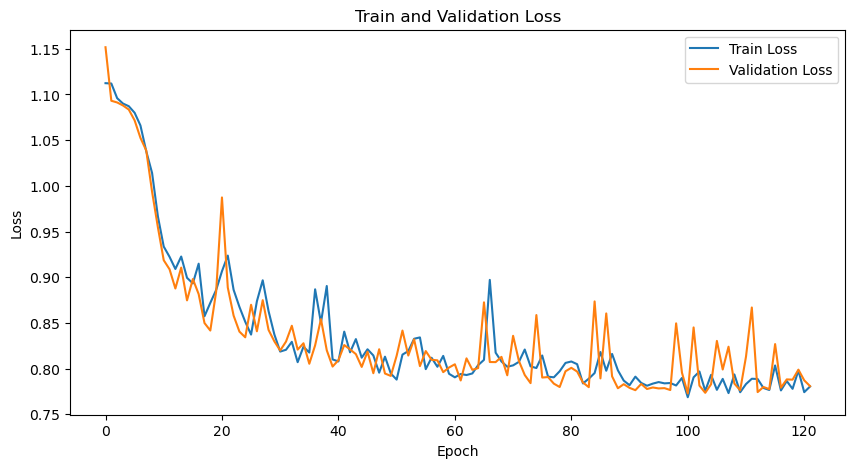

In [47]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# 初始化优化器、损失函数和学习率调度器
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6, verbose=True)
loss_func = nn.CrossEntropyLoss()
writer = SummaryWriter(logdir='C:/Users/22209/Desktop/气体论文/Woodgass/resnet1d/logs/acnn')

n_epoch = 250
step = 0
prev_f1 = 0
patience_counter = 0  # Early stopping counter
best_val_loss = float('inf')
train_losses, val_losses = [], []

# Training and validation loops
for epoch in tqdm(range(n_epoch), desc="Epoch", leave=False):

    # Training phase
    model.train()
    running_loss = 0.0
    prog_iter = tqdm(dataloader, desc="Training", leave=False)
    for batch_idx, batch in enumerate(prog_iter):
        input_x, input_y = tuple(t.to(device) for t in batch)
        optimizer.zero_grad()
        pred = model(input_x)
        loss = loss_func(pred, input_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        step += 1

        writer.add_scalar('Loss/train', loss.item(), step)

        if is_debug:
            break

    train_loss = running_loss / len(dataloader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader_test, desc="Validation", leave=False)):
            input_x, input_y = tuple(t.to(device) for t in batch)
            pred = model(input_x)
            loss = loss_func(pred, input_y)
            val_loss += loss.item()

    val_loss /= len(dataloader_test)
    val_losses.append(val_loss)
    writer.add_scalar('Loss/train', loss.item(), step)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")
    
    # Save model if current validation loss is the lowest
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'C:/Users/22209/Desktop/气体论文/Woodgass/resnet1d/output/acnn/acnn_best.pt')
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter > 20:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if is_debug:
        break

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.savefig('train_val_loss.png')
plt.show()

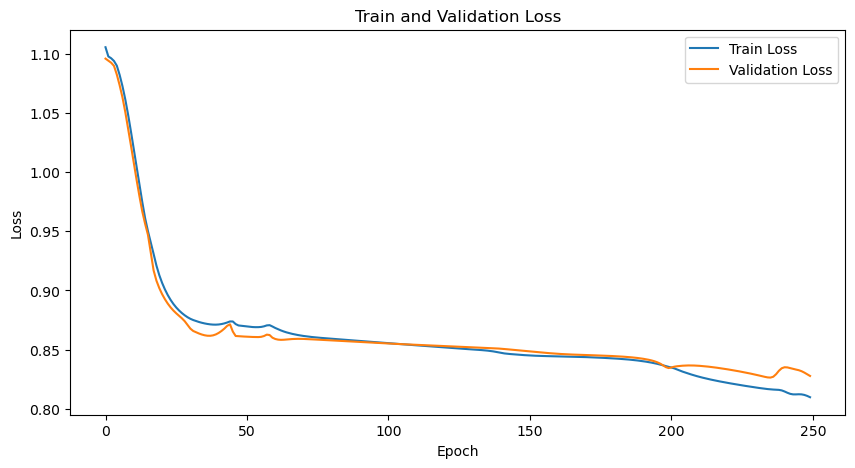

In [34]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.savefig('train_val_loss.png')
plt.show()

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: 0.6796
Precision: 0.7052
Recall: 0.6796
F1 Score: 0.6856
[[133  47  10]
 [ 10  90  63]
 [  2  41 144]]
              precision    recall  f1-score   support

           0       0.92      0.70      0.79       190
           1       0.51      0.55      0.53       163
           2       0.66      0.77      0.71       187

    accuracy                           0.68       540
   macro avg       0.70      0.67      0.68       540
weighted avg       0.71      0.68      0.69       540



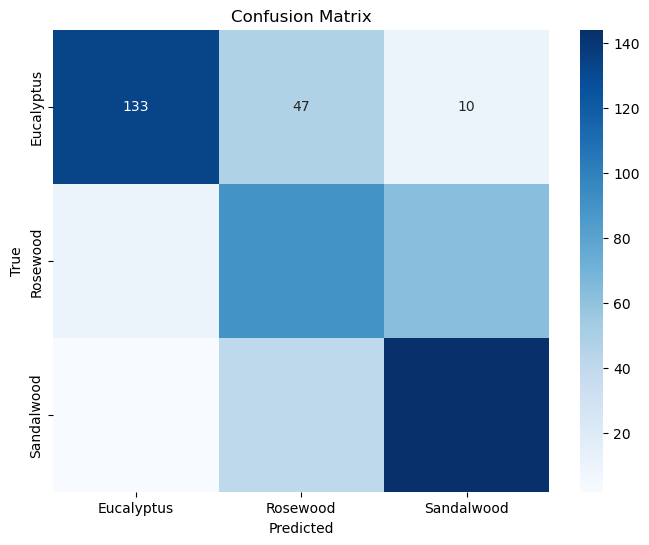

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model_path, dataloader_test, device, label_names):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_pred_prob = []
    all_true_labels = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader_test, desc="Evaluating", leave=False)):
            input_x, input_y = tuple(t.to(device) for t in batch)
            pred = model(input_x)
            all_pred_prob.append(pred.cpu().data.numpy())
            all_true_labels.append(input_y.cpu().data.numpy())

    all_pred_prob = np.concatenate(all_pred_prob)
    all_true_labels = np.concatenate(all_true_labels)
    all_pred = np.argmax(all_pred_prob, axis=1)

    # Calculate and print metrics
    accuracy = accuracy_score(all_true_labels, all_pred)
    precision = precision_score(all_true_labels, all_pred, average='weighted')
    recall = recall_score(all_true_labels, all_pred, average='weighted')
    f1 = f1_score(all_true_labels, all_pred, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(confusion_matrix(all_true_labels, all_pred))
    print(classification_report(all_true_labels, all_pred))

    # Plot confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

# Use the evaluation function with the best model
label_names=['Eucalyptus','Rosewood','Sandalwood']
evaluate_model('C:/Users/22209/Desktop/气体论文/Woodgass/resnet1d/output/acnn/acnn_best.pt', dataloader_test, device, label_names)
